<a href="https://colab.research.google.com/github/alinakhaee/LFW-Ensemble-Learning/blob/main/LFW_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Create Dataset
In the beginnig, we read the `pairsDevTest.txt` and `pairsDevTrain.txt` files and create our dataset. <br>
Our final datasets are a 2200\*1024 array for train and 1000\*1024 array for test. <br>
We have computed the feature points of each image and we transfered them to vectors with 512 dimensions. Therefore each row of our dataset contains 1024 columns, first 512 columns is the feature points of image and second 512 columns are the feature points of second image. <br>
The labels for our dataset is True and False. True means the two images is represting the same person, and False means that the two image are showing different persons.

In [ ]:
import numpy as np

def read_features_from_file(file_name):
    feature_file = open(file_name, "r")
    feature_lines = feature_file.readlines()
    feature_file.close()
    features_list = []
    for feature_line in feature_lines:
        feature_line = feature_line.replace('[[', '').replace(']]', '').strip()
        features = list(map(lambda a : float(a), feature_line.split()))
        features_list.extend(features)
    return features_list
        
def create_dataset(filename):
    file = open(filename, "r")
    lines = file.readlines()
    file.close()
    x_list = []
    y_list = []

    for line in lines:
        splitted = line.split()
        row = []
        if len(splitted) == 3:
            name1 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[1]).zfill(4), 'txt')
            name2 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[2]).zfill(4), 'txt')
            row.extend(read_features_from_file(name1))
            row.extend(read_features_from_file(name2))
            y_list.append(True)
            x_list.append(row)
        if len(splitted) == 4:
            name1 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[1]).zfill(4), 'txt')
            name2 = "project/lfw/{}/{}_{}.{}".format(splitted[2], splitted[2], str(splitted[3]).zfill(4), 'txt')
            row.extend(read_features_from_file(name1))
            row.extend(read_features_from_file(name2))
            y_list.append(False)
            x_list.append(row)
    return x_list, y_list

x_train, y_train = create_dataset('project/pairsDevTrain.txt')
x_test, y_test = create_dataset('project/pairsDevTest.txt')
    
print(len(x_train))
print(len(x_test))

2200
1000


# 2. Voting Classifier
The idea behind the `VotingClassifier` is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. <br>
Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.<br>
It is the simplest ensemble method. All we have to do is to choose `n` different learners and train all of them with the same dataset. Then for each row of test dataset we check the prediction of each learner and choose the label that was repeated most. <br>
First thing we need to do is to choose our models. The Classifiers that we have studied so far are DT, SVM and MLP. <br>
For each of these classifiers, we define 3 models with different parameters and vote among 9 different models.

## 2.1. Decision Tree
In exercise 2, we have discussed Decision Trees in details. <br>
There are two main parameters we can set for a `DecisionTreeClassifier` in `sklearn` library and they are:
*   `max_depth` : <br>
The maximum depth of the tree while training. <br>
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. <br>
🟣 default value: `None`

*   `criterion` : <br>
The function to measure the quality of a split. Supported criteria are `“gini”` for the Gini impurity and `“entropy”` for the information gain. <br>
🟣 default value: `"gini"` <br>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, rand_score

def do_decision_tree(decision_tree: DecisionTreeClassifier, print_result= True):
    decision_tree.fit(x_train, y_train)
    train_predict = decision_tree.predict(x_train)
    test_predict = decision_tree.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()

decision_tree_1 = DecisionTreeClassifier() # gini - full tree
decision_tree_2 = DecisionTreeClassifier(criterion='entropy') # entropy - full tree
decision_tree_3 = DecisionTreeClassifier(max_depth=10) # gini - 15 depth
decision_tree_4 = DecisionTreeClassifier(max_depth=5) # gini - 15 depth
do_decision_tree(decision_tree_1)
do_decision_tree(decision_tree_2)
do_decision_tree(decision_tree_3)
do_decision_tree(decision_tree_4)

Test Data Purity : 56.0%
Test Data Rand-Index : 50.67%

Test Data Purity : 53.2%
Test Data Rand-Index : 50.15%

Test Data Purity : 56.4%
Test Data Rand-Index : 50.77%

Test Data Purity : 53.4%
Test Data Rand-Index : 50.18%



In the above code we train four different DT models and as it is clear, the first 3 models had the best result and we choose them for out `VotingClassifier`

## 2.2. SVM
In exercise 3 we discussed SVM in details. <br>
The most important parameters for `SVC` in `sklearn` library are:

*   `kernel` : <br>
Specifies the kernel type to be used in the algorithm. <br>
The most famous kernels are: `{'linear', 'poly', 'rbf', 'sigmoid'}` . <br>
🟣 default value: `rbf`
*   `degree` : <br>
Degree of the polynomial kernel function (`‘poly’`). Ignored by all other kernels. <br>
🟣 default value: `3`
*   `C` : <br>
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. <br>
🟣 default value: `1.0`
*   `gamma` : <br>
Kernel coefficient for `‘rbf’`, `‘poly’` and `‘sigmoid’`. <br>
🟣 default value: `scale` 


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, rand_score

def do_svm(svm, print_result= True):
    svm.fit(x_train, y_train)
    train_predict = svm.predict(x_train)
    test_predict = svm.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()

svm_1 = SVC(kernel='rbf', C=4)
svm_2 = SVC(kernel='poly', degree=4, C=4)
svm_3 = SVC(kernel='poly', degree=6)
svm_4 = SVC(kernel='sigmoid', C=4)
svm_5 = SVC(kernel='rbf', C=3)
svm_6 = SVC(kernel='rbf', C=6)
do_svm(svm_1)
do_svm(svm_2)
do_svm(svm_3)
do_svm(svm_4)
do_svm(svm_5)
do_svm(svm_6)

Test Data Purity : 77.9%
Test Data Rand-Index : 65.53%

Test Data Purity : 77.1%
Test Data Rand-Index : 64.65%

Test Data Purity : 77.6%
Test Data Rand-Index : 65.2%

Test Data Purity : 43.6%
Test Data Rand-Index : 50.77%

Test Data Purity : 77.8%
Test Data Rand-Index : 65.42%

Test Data Purity : 77.6%
Test Data Rand-Index : 65.2%



In the above code we train 6 SVMs with different kernels and parameters and we choose the three best models for our `VotingClassifier`.

## 2.3. MLP
Class `MLPClassifier` implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. <br>
In `MLPClassifier` the most important parameters are:

*   `hidden_layer_sizes` : <br>
It is a tuple and the ith element represents the number of neurons in the ith hidden layer. <br>
For example (20, 30, 40) means 3 hidden layer with different sizes. <br>
🟣 default value: `(100,)`
*   `activation` : <br>
Activation function for the hidden layer.<br>
`‘identity’`, no-op activation, useful to implement linear bottleneck, returns f(x) = x <br>
`‘logistic’`, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)). <br>
`‘tanh’`, the hyperbolic tan function, returns f(x) = tanh(x). <br>
`‘relu’`, the rectified linear unit function, returns f(x) = max(0, x) <br>
🟣 default value: `relu` <br>
*   `learning_rate` : <br>
Learning rate schedule for weight updates. <br>
It can be one of: {`‘constant’`, `‘invscaling’`, `‘adaptive’`} <br>
🟣 default value: `scale` 
*   `max_iter` : <br>
Maximum number of iterations. The solver iterates until convergence or this number of iterations. <br>
🟣 default value: `200` 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, rand_score

def do_mlp(mlp, print_result= True):
    mlp.fit(x_train, y_train)
    train_predict = mlp.predict(x_train)
    test_predict = mlp.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()

mlp_1 = MLPClassifier()
mlp_2 = MLPClassifier(hidden_layer_sizes=(200, 100))
mlp_3 = MLPClassifier(hidden_layer_sizes=(500, 500))
mlp_4 = MLPClassifier(activation="tanh", learning_rate='adaptive')
mlp_5 = MLPClassifier(activation="logistic", learning_rate='invscaling')
mlp_6 = MLPClassifier(max_iter=100)
mlp_7 = MLPClassifier(max_iter=1000)
do_mlp(mlp_1)
do_mlp(mlp_2)
do_mlp(mlp_3)
do_mlp(mlp_4)
do_mlp(mlp_5)
do_mlp(mlp_6)
do_mlp(mlp_7)

Test Data Purity : 73.9%
Test Data Rand-Index : 61.39%

Test Data Purity : 74.9%
Test Data Rand-Index : 62.36%

Test Data Purity : 73.5%
Test Data Rand-Index : 61.01%

Test Data Purity : 70.7%
Test Data Rand-Index : 58.53%

Test Data Purity : 72.5%
Test Data Rand-Index : 60.09%

Test Data Purity : 73.2%
Test Data Rand-Index : 60.73%

Test Data Purity : 71.9%
Test Data Rand-Index : 59.55%



We train some MLP Classifiers with different network shape and paramaters and we keep thee best models for our voting system.

## 2.4. Voting Classifier
Now that we train lots of models with different parameters and different algorithms, we now want to make a voting system and check if our result is better than each model individually or not. <br>

In [ ]:
from sklearn.ensemble import VotingClassifier

def do_voting(voting, print_result= True):
    voting.fit(x_train, y_train)
    train_predict = voting.predict(x_train)
    test_predict = voting.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
        
voting = VotingClassifier(estimators=[
        ('dt1', decision_tree_1), ('dt2', decision_tree_3), ('dt3', decision_tree_4),
        ('svm1', svm_1), ('svm2', svm_3), ('svm3', svm_5), ('svm4', svm_6),
        ('mlp1', mlp_1), ('mlp2', mlp_3), ('mlp3', mlp_7),
])
do_voting(voting)

Test Data Purity : 78.4%
Test Data Rand-Index : 66.1%



As you can see, the accuracy that we get after using the voting system is better than each individual classifier. <br>
In the above code we are considering the same weight for each classifier. but as we saw, the accuracy for Decision Trees were so much less than SVM and MLP and we need to give lower weight to DT and higher weight to SVMs and MLPs. <br>
According to the accuracy of each individual model, we divide the weights as follow: <br>
* `dt1`: `1`
* `dt2`: `1.3`
* `dt3`: `1`
* `svm1`: `2.5`
* `svm2`: `2.3`
* `svm3`: `2.3`
* `svm4`: `2.3`
* `mlp1`: `2.4`
* `mlp2`: `2.3`
* `mlp3`: `2.1`

In [ ]:
voting = VotingClassifier(estimators=[
        ('dt1', decision_tree_1), ('dt2', decision_tree_3), ('dt3', decision_tree_4),
        ('svm1', svm_1), ('svm2', svm_3), ('svm3', svm_5), ('svm4', svm_6),
        ('mlp1', mlp_1), ('mlp2', mlp_3), ('mlp3', mlp_7),],
                         weights=[1, 1.3, 1, 2.5, 2.3, 2.3, 2.3, 2.4, 2.3, 2.1])
do_voting(voting)

Test Data Purity : 78.8%
Test Data Rand-Index : 66.56%



As you can see, after we added weight to out models, we get a little better accuracy and for sure this accuracy is still more than each model individually. <br>
So we infer that by voting amongst some weak classifiers, we can get a better accuracy and make a slightly stronger model.

# 3. Bagging Classifier
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. <br>
Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. <br>
In `BaggingClassifier` of `sklearn` library the most important parameters are:
*   `base_estimator` : <br>
The base estimator to fit on random subsets of the dataset. <br>
🟣 default value: `DecisionTreeClassifier`
*   `n_estimators` : <br>
The number of base estimators in the ensemble.<br>
🟣 default value: `10` <br>
*   `bootstrap` : <br>
Whether samples are drawn with replacement or not. If False, sampling without replacement is performed. <br>
🟣 default value: `True` 

## 3.1. Test different models
First of all, we want to check all the different models that we have trained so far and see which model gets higher improvement. <br>

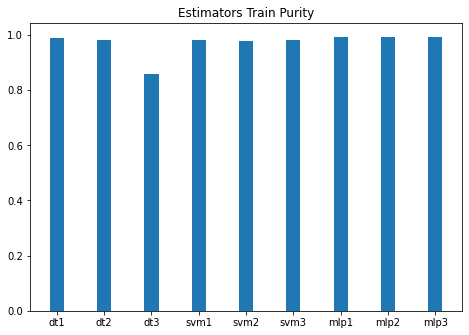

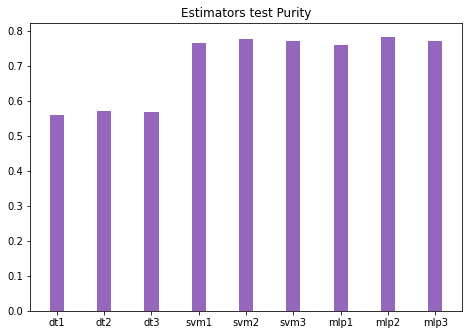

In [ ]:
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

def show_bar_chart(x, y, title, color):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.title.set_text(title)
    ax.bar(x, y, color=color, width=0.3)
    plt.show()

def do_bagging(bagging, print_result=True):
    bagging.fit(x_train, y_train)
    train_predict = bagging.predict(x_train)
    test_predict = bagging.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
    return train_purity, test_purity

base_estimators = [decision_tree_1, decision_tree_3, decision_tree_4,
                  svm_1, svm_2, svm_3,
                  mlp_1, mlp_3, mlp_7]
base_estimators_str = ['dt1', 'dt2', 'dt3', 'svm1', 'svm2', 'svm3', 'mlp1', 'mlp2', 'mlp3']
train_purities = []
test_purities = []
for base_estimator in base_estimators :
    bagging = BaggingClassifier(base_estimator=base_estimator)
    train_purity, test_purity = do_bagging(bagging, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)

show_bar_chart(base_estimators_str, train_purities,'Estimators Train Purity', 'tab:blue')
show_bar_chart(base_estimators_str, test_purities,'Estimators test Purity', 'tab:purple')

From the plots we can see that the second MLP classifiers get the accuracy of near 79% and it is a great improvment, since this models has 73.5% accuracy individually but after bagging it produces the most accurate answer. <br>
The decision trees doesn't get much improvment after using the bagging system. <br>
The SVMs models have average 77% accuracy individually and after bagging, they got the same accuracy, and even less acuuracy. <br>
But for the MLPs we can see that we had a great improvment and turn our models from 73.5% to near 80% accuracy. <br>

## 3.2. Number of estimators
From the previous section we can infer that `BaggingClassifier` works well for MLPs and somehow DTs, but doesn't have good effects on SVMs.<br>
Now we want to check number of estimators and from now on, we use `mlp_3` as our `base_estimator` since it has the highest performance.

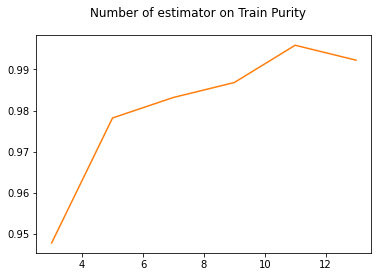

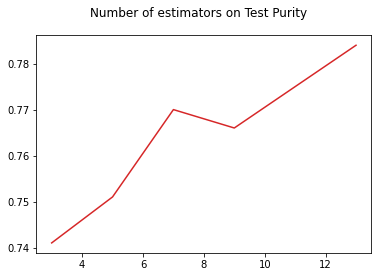

In [ ]:
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
   
n_estimators = [3, 5, 7, 9, 11, 13]
train_purities = []
test_purities = []
for n_estimator in n_estimators :
    bagging = BaggingClassifier(base_estimator=mlp_3, n_estimators=n_estimator)
    train_purity, test_purity = do_bagging(bagging, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(n_estimators, train_purities, 'tab:orange')
plt.suptitle('Number of estimator on Train Purity')
plt.show()
plt.plot(n_estimators, test_purities, 'tab:red')
plt.suptitle('Number of estimators on Test Purity')
plt.show()

In the above code we used the MLP model with 6 different `n_estimators` and see the result. <br>
As you can see in the plots, by increasing the number of estimators we get better performance and by using 13 estimators, we get 79% accuracy which is much more than the MLP individually which was 73.5% <br>
So we infer that by increasing number of estimators, we can lower the overfitting and therfore increasing the accuracy for our model. <br>

## 3.3. Replacement vs No Replacement
Up to now we used bootstraping, or replacement for our bagging models. Now we want to check the result if we train our estimators with no replacement. 

In [ ]:
bagging = BaggingClassifier(base_estimator=mlp_3, n_estimators=13, bootstrap=False)
do_bagging(bagging)

Test Data Purity : 78.5%
Test Data Rand-Index : 66.21%



(1.0, 0.785)

The accuracy that we got with replacement (previous section) was 80% for test and 99% for train data. <br>
Now by applying No Replacement, we got 100% accuracy for train and 78.5% accuracy for test. which means that our model has gotten more overfitted to the dataset and doesn't work as good as replacement method on test data. <br>
The reason is clear, because in replacement method, almost 37% of our train data will never be picked and this will prevent our model from overfitting. <br>

# 4. Stacking Classifier
Stacked generalization is a method for combining estimators to reduce their biases. <br>
More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation. <br>
<br>
Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. <br>
Note that estimators are fitted on the full dataset while final estimator is trained using cross-validated predictions of the base estimators using `cross_val_predict`. <br>
There are three main parameter for this classifier and they are: <br>
*   `estimators` : <br>
Base estimators which will be stacked together. Each element of the list is defined as a tuple of string (i.e. name) and an estimator instance. <br>
🟣 default value: IT IS REQUIRED
*   `final_estimator` : <br>
A classifier which will be used to combine the base estimators.<br>
🟣 default value: `LogisticRegression` <br>
*   `cv` : <br>
Determines the `cross-validation` splitting strategy used in `cross_val_predict` to train `final_estimator`. <br>
It uses KFold strategy and we have to determine number of K. <br>
🟣 default value: `5`
<br>

## 4.1. Estimators
Initially we train 9 of our previous models and use default values for other parameters.

In [ ]:
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt

def do_stacking(stacking, print_result=True):
    stacking.fit(x_train, y_train)
    train_predict = stacking.predict(x_train)
    test_predict = stacking.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
    return train_purity, test_purity

estimators = [
     ('dt1', decision_tree_1), ('dt2', decision_tree_3), ('dt3', decision_tree_4),
     ('svm1', svm_1), ('svm2', svm_3), ('svm3', svm_5), ('svm4', svm_6),
     ('mlp1', mlp_1), ('mlp2', mlp_3), ('mlp3', mlp_7)
]
stacking = StackingClassifier(estimators=estimators)
do_stacking(stacking)

Test Data Purity : 77.5%
Test Data Rand-Index : 65.09%



(1.0, 0.775)

After using the stacking classifier, we get 77.5% accuracy which is more than most of the models individually. <br>
In the above Stacking Classifier, we used the `LogisticRegression` as the final estimator. <br>
Now we want to decrease the size of estimators and choose the three best individual models and then see the result. <br>

In [ ]:
estimators = [
     ('svm1', svm_1), ('svm2', svm_5),('mlp1', mlp_2)
]
stacking = StackingClassifier(estimators=estimators)
do_stacking(stacking)

Test Data Purity : 78.8%
Test Data Rand-Index : 66.56%



(1.0, 0.788)

By choosing less models in our Stacking Classifier, we get 78.8% accuracy which is more than all of our individual models.

## 4.2. Final Estimator
Up to now we were working with the `LogisticRegression` which was the default value for final estimator. <br>
Now we want to use other models we have learned so far and use them as final estimator and see the result. <br>

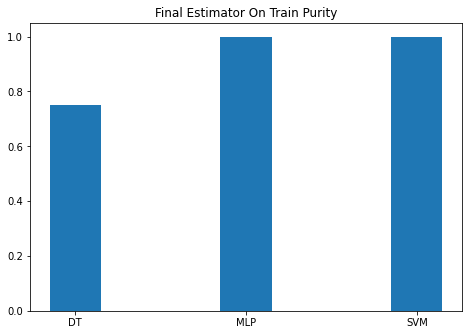

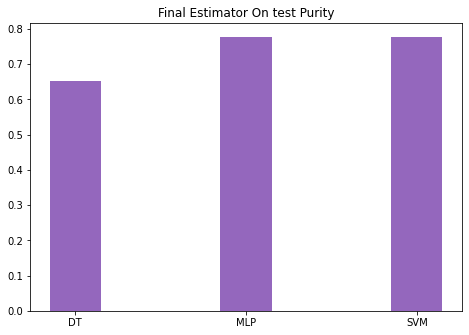

In [ ]:
def show_bar_chart(x, y, title, color):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.title.set_text(title)
    ax.bar(x, y, color=color, width=0.3)
    plt.show()
    
final_estimators = [DecisionTreeClassifier(), MLPClassifier(), SVC()]
final_estimators_str = ['DT', 'MLP', 'SVM']
train_purities = []
test_purities = []
for final_estimator in final_estimators :
    stacking = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
    train_purity, test_purity = do_stacking(stacking, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)

show_bar_chart(final_estimators_str, train_purities,'Final Estimator On Train Purity', 'tab:blue')
show_bar_chart(final_estimators_str, test_purities,'Final Estimator On test Purity', 'tab:purple')

As it is clear in the plots, by choosing `DecisionTreeClassifier` as the  final estimator, we get 65% accuracy, and by choosing MLP and SVM, we get 77% accuracy; which all of them are less than the `LogisticRegression` that we used in previous section which was 78.8%. <br>
So we infer that the `LogisticRegression` works best as final estimator and we keep using it.

## 4.3. Cross Validation
The Stacking Classifier uses K-Fold strategy to split inputs. <br>
Up to now we have used 5-Fold and now we want to check this parameter.

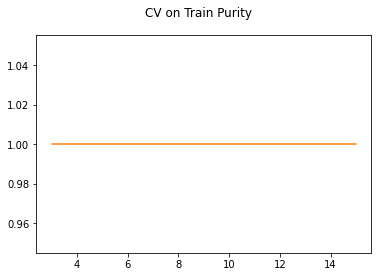

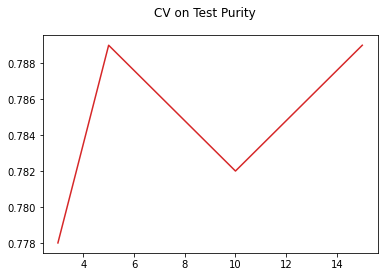

In [ ]:
import matplotlib.pyplot as plt
   
cvs = [3, 5, 10, 15]
train_purities = []
test_purities = []
for cv in cvs :
    stacking = StackingClassifier(estimators=estimators, cv=cv)
    train_purity, test_purity = do_stacking(stacking, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(cvs, train_purities, 'tab:orange')
plt.suptitle('CV on Train Purity')
plt.show()
plt.plot(cvs, test_purities, 'tab:red')
plt.suptitle('CV on Test Purity')
plt.show()

As you can see in the plots, the `cv` parameters have no effect on the train dataset, but on the test dataset, `cv=5` and `cv=15` has the same effect and they had 78.9% accuracy, but for `cv=3` and `cv=10` we have lost a bit of accuracy. <br>
Totally, we infer that this parameter doesn't have too much effect on the accuracy .

# 5. Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.<br>
There are three main paramaters which are:
*   `n_estimators` : <br>
The number of trees in the forest. <br>
🟣 default value: `100`
*   `criterion` : <br>
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.<br>
🟣 default value: `"gini"` <br>
*   `max_depth` : <br>
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure. <br>
🟣 default value: `None`
<br>

## 5.1. Number of Trees
In this part we are checking the effect of tree numbers on accuracy. <br>
We have to mention that by using Decision Tree Classifier individually, we got 56.4% accuracy at most. <br>
Now we want to see if Random Forest Classifier can help us improve this number.

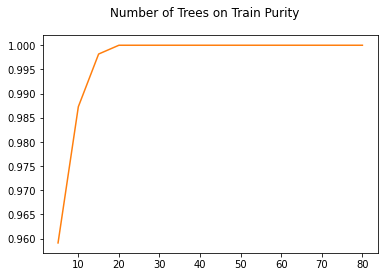

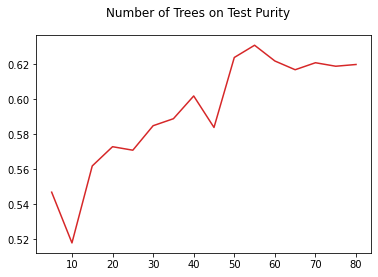

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def do_random_forest(random_forest, print_result=True):
    random_forest.fit(x_train, y_train)
    train_predict = random_forest.predict(x_train)
    test_predict = random_forest.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
    return train_purity, test_purity

n_estimators = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
train_purities = []
test_purities = []
for n_estimator in n_estimators :
    random_forest = RandomForestClassifier(n_estimators=n_estimator)
    train_purity, test_purity = do_random_forest(random_forest, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(n_estimators, train_purities, 'tab:orange')
plt.suptitle('Number of Trees on Train Purity')
plt.show()
plt.plot(n_estimators, test_purities, 'tab:red')
plt.suptitle('Number of Trees on Test Purity')
plt.show()

As you can see in the plots, by increasing the number of trees, we get more and more accuracy. <br>
The accuracy that we got by an individual Decision Tree, was at most 56.4%. But after performing a Random Forest Classifier with 55 trees, we get 64% accuracy which is much much more than an individual tree. <br>
Also we have to mention that the compution time for Random Forest is so much short and comparing to other ensemble methods, random forest finds converges too much faster. <br>


## 5.2. Criterion
In the previous section we found out that by choosing `n_estimators=55` we would get the highest accuracy. <br>
The previous section result was with `"gini"` strategy. Now we want to test Random Forest with `"entropy"` strategy and see the result.

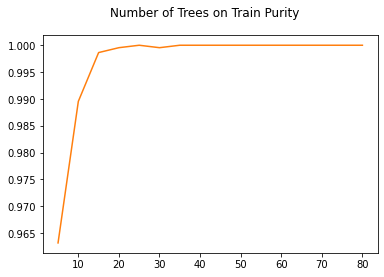

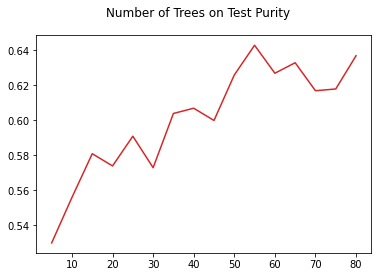

In [ ]:
n_estimators = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
train_purities = []
test_purities = []
for n_estimator in n_estimators :
    random_forest = RandomForestClassifier(n_estimators=n_estimator, criterion='entropy')
    train_purity, test_purity = do_random_forest(random_forest, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(n_estimators, train_purities, 'tab:orange')
plt.suptitle('Number of Trees on Train Purity')
plt.show()
plt.plot(n_estimators, test_purities, 'tab:red')
plt.suptitle('Number of Trees on Test Purity')
plt.show()

We use the same number of trees and plot them, but this time we use the entropy strategy for classifier. <br>
The difference of the accuracies is not too much, but we can tell that the entropy method is slightly better than the gini. However the entropy takes a little more time to be computed. 

## 5.3. Max Depth
Another important parameter in Decision Tree and Random Forest is `max_depth`. <br>
Instead of creating the whole tree, which results into overfitting, we creaate the tree to a pre-defined depth. <br>
In previous sections we infer that the best Random Forest Classifier is with 55 tress and entropy method, therefore we use this model to test the max depth parameter.

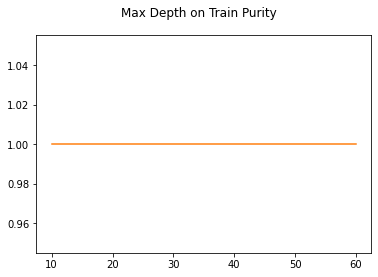

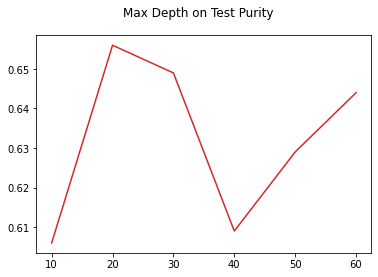

In [ ]:
max_depths = [10, 20, 30, 40, 50, 60]
train_purities = []
test_purities = []
for max_depth in max_depths :
    random_forest = RandomForestClassifier(n_estimators=55, criterion='entropy', max_depth=max_depth)
    train_purity, test_purity = do_random_forest(random_forest, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(max_depths, train_purities, 'tab:orange')
plt.suptitle('Max Depth on Train Purity')
plt.show()
plt.plot(max_depths, test_purities, 'tab:red')
plt.suptitle('Max Depth on Test Purity')
plt.show()

As it is clear in the plots, by choosing `max_depth=20` we get almost 66% accuracy which is more than the random forests in previous sections. <br>
The reason for this is that by preventing the algorithm to create the full tree, we prevent the random forest classifier from being overfitted.

# 6. AdaBoost
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. <br>
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as very small decision trees) on repeatedly modified versions of the data. <br>

There are two main parameter for Ada Boost Classifier and they are: <br>
*   `base_estimator` : <br>
The base estimator from which the boosted ensemble is built. If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1. <br>
🟣 default value: `DecisionTreeClassifier(max_depth=1)`
*   `n_estimators` : <br>
The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.<br>
🟣 default value: `50` <br>

## 6.1. Base Estimator
The Important thing to mention is that the `base_estimator` must be a classifier which support sample weighting. <br>
Unfortunately the MLPClassifier does not support sample weighting, therefore we just test the Decision Tree and SVM as `base_estimator`.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

def do_boosting(boosting, print_result=True):
    boosting.fit(x_train, y_train)
    train_predict = boosting.predict(x_train)
    test_predict = boosting.predict(x_test)
    train_purity = accuracy_score(train_predict, y_train)
    train_rand_index = rand_score(train_predict, y_train)
    test_purity = accuracy_score(test_predict, y_test)
    test_rand_index = rand_score(test_predict, y_test)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
    return train_purity, test_purity

clf = AdaBoostClassifier(n_estimators=50, base_estimator=SVC(), algorithm='SAMME')
do_boosting(clf)

Test Data Purity : 63.4%
Test Data Rand-Index : 53.54%



(0.725909090909091, 0.634)

In [ ]:
clf = AdaBoostClassifier(n_estimators=50, base_estimator=DecisionTreeClassifier(), algorithm='SAMME')
do_boosting(clf)

Test Data Purity : 55.1%
Test Data Rand-Index : 50.47%



(1.0, 0.551)

In the two code sections above, we train an `AdaBoostClassifier` once with Decission Tree and once with SVM. <br>
The result that we get is not so much. however it is better for SVM, altough it takes so so much time to be executed. <br>
The reason that we didn't get much accuracy, is that we haven't used the power of Ada Boost correctly. <br>
Ada Boost is a classifier that combines lots of weak classifiers and create a strong classifier. <br>
A weak classifier is a classifier that is executed too fast, is not complex at all, does not overfit. <br>
By using a full Decision Tree and a full SVM as our base estimators, we are combining strong classifiers in a wrong way, therefore we get a lower accuracy than each individual estimator. <br>
We should use basic and simple estimators, for example a Decision Tree with `max_depth=1` or an SVM with `max_iter=10`. <br>
So we will use these simple classifiers and check the result of them.

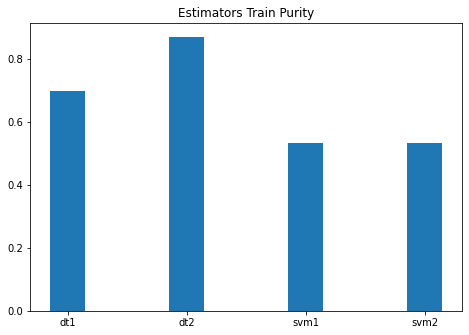

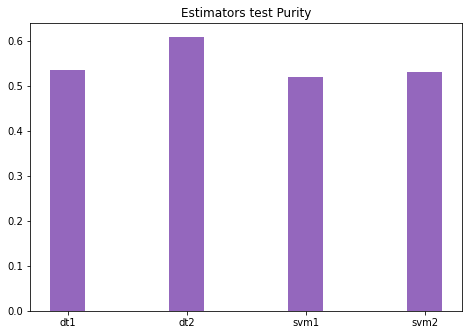

In [ ]:
import matplotlib.pyplot as plt

def show_bar_chart(x, y, title, color):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.title.set_text(title)
    ax.bar(x, y, color=color, width=0.3)
    plt.show()

base_estimators = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),
                  SVC(max_iter=5), SVC(max_iter=10)]
base_estimators_str = ['dt1', 'dt2', 'svm1', 'svm2']
train_purities = []
test_purities = []
for base_estimator in base_estimators :
    boosting = AdaBoostClassifier(base_estimator=base_estimator, algorithm='SAMME')
    train_purity, test_purity = do_boosting(boosting, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)

show_bar_chart(base_estimators_str, train_purities,'Estimators Train Purity', 'tab:blue')
show_bar_chart(base_estimators_str, test_purities,'Estimators test Purity', 'tab:purple')

From the plots we infer that, unlike our previous code block, now the weak version of Decision Trees have better accuracy than the SVM. also by comparing the result of this weak classifiers, we can see that by combining weak classifiers, we get more accuracy than with combining strong classifiers.

## 6.2. Number of Estimators
Another important parameter is the number of estimators. <br>
Up to now we have used 50 estimators for our tests. but we will get more accuracy if we use more estimators, the reason is that we combine more weak classifiers and we detect more difficult cases.

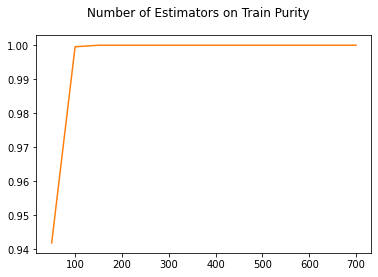

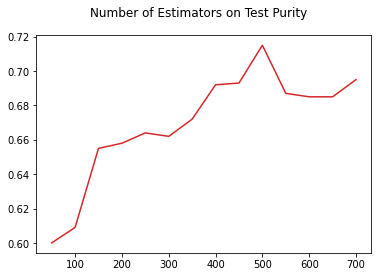

In [ ]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
train_purities = []
test_purities = []
for n_estimator in n_estimators :
    boosting = AdaBoostClassifier(n_estimators=n_estimator, base_estimator=DecisionTreeClassifier(max_depth=2))
    train_purity, test_purity = do_boosting(boosting, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(n_estimators, train_purities, 'tab:orange')
plt.suptitle('Number of Estimators on Train Purity')
plt.show()
plt.plot(n_estimators, test_purities, 'tab:red')
plt.suptitle('Number of Estimators on Test Purity')
plt.show()

As it is clear in the plots, by increasing the number of estimators, we get much more accuracy. <br>
We were using a weak decision tree that would have 50% accuracy (random guess) individually, and by combining this weak decision tree 500 times, we get 72% accuracy which is almost a good accuracy. 

## 6.3 Changing the dataset
The AdaBoost Classifier is known to be a classifier that combine weak classifiers to create a strong one. <br>
These weak classifiers must be so simple, just like performing a threshold on a column of dataset. <br>
Our main dataset had 1024 columns, which was a large amount and this would prevent our `AdaBoostClassifier` to unleash its powers. <br>
Therefore we change our datatset and instead of 1024 columns, we now have one column, and that column is the euclidian vector distance between the VGG of the two images. <br>
We suppose that by doing this simplification, we would get better accuracy for our Ada Boost Classifier. <br>

In [ ]:
def create_dataset_adaboost(filename):
    file = open(filename, "r")
    lines = file.readlines()
    file.close()
    x_list = []
    y_list = []

    for line in lines:
        splitted = line.split()
        row = []
        if len(splitted) == 3:
            name1 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[1]).zfill(4), 'txt')
            name2 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[2]).zfill(4), 'txt')
            dist = np.linalg.norm(np.array(read_features_from_file(name1))-np.array(read_features_from_file(name2)))
            y_list.append(True)
            x_list.append(dist)
        if len(splitted) == 4:
            name1 = "project/lfw/{}/{}_{}.{}".format(splitted[0], splitted[0], str(splitted[1]).zfill(4), 'txt')
            name2 = "project/lfw/{}/{}_{}.{}".format(splitted[2], splitted[2], str(splitted[3]).zfill(4), 'txt')
            dist = np.linalg.norm(np.array(read_features_from_file(name1))-np.array(read_features_from_file(name2)))
            y_list.append(False)
            x_list.append(dist)
    return x_list, y_list

x_train2, y_train2 = create_dataset_adaboost('project/pairsDevTrain.txt')
x_test2, y_test2 = create_dataset_adaboost('project/pairsDevTest.txt')

x_train2 = np.array(x_train2).reshape(-1, 1)
x_test2 = np.array(x_test2).reshape(-1, 1)

print(len(x_train2))
print(len(x_test2))

2200
1000


### 6.3.1. Decision Tree on new Dataset

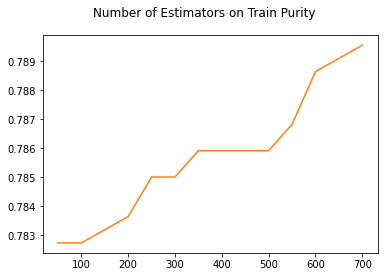

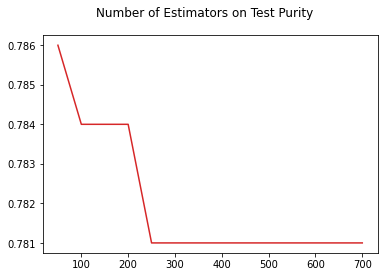

In [ ]:
def do_boosting2(boosting, print_result=True):
    boosting.fit(x_train2, y_train2)
    train_predict = boosting.predict(x_train2)
    test_predict = boosting.predict(x_test2)
    train_purity = accuracy_score(train_predict, y_train2)
    train_rand_index = rand_score(train_predict, y_train2)
    test_purity = accuracy_score(test_predict, y_test2)
    test_rand_index = rand_score(test_predict, y_test2)
    if print_result:
        print(f'Test Data Purity : {round(test_purity * 100, 2)}%')
        print(f'Test Data Rand-Index : {round(test_rand_index * 100, 2)}%')
        print()
    return train_purity, test_purity

n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
train_purities = []
test_purities = []
for n_estimator in n_estimators :
    boosting = AdaBoostClassifier(n_estimators=n_estimator, base_estimator=DecisionTreeClassifier(max_depth=1))
    train_purity, test_purity = do_boosting2(boosting, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(n_estimators, train_purities, 'tab:orange')
plt.suptitle('Number of Estimators on Train Purity')
plt.show()
plt.plot(n_estimators, test_purities, 'tab:red')
plt.suptitle('Number of Estimators on Test Purity')
plt.show()

In the above code, we had used different numbers as `n_estimators` and we used a Decision Tree classifier with `max_depth=1` (i.e, thresholding) to train our AdaBoost Classifier. <br>
As you can see, we get 78.6% accuracy by using 50 estimators and by increasing this number, we will lose accuracy. <br>
However as we expected, this accuracy is much more than the accuracy that we got with previous dataset.

### 6.3.2. SVM on new Dataset
In the previous section we discussed the DT on our new dataset, now we want to test SVM on our new dataset. <br>
With previous datset we got less accuracy with a weak SVM. <br>

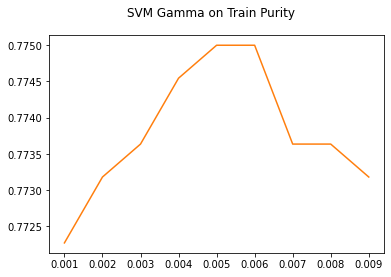

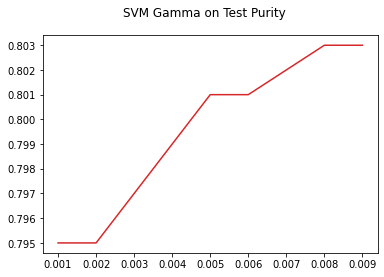

In [ ]:
gammas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
train_purities = []
test_purities = []
for gamma in gammas :
    boosting = AdaBoostClassifier(base_estimator=SVC(gamma=gamma), algorithm='SAMME')
    train_purity, test_purity = do_boosting2(boosting, False)
    train_purities.append(train_purity)
    test_purities.append(test_purity)


plt.plot(gammas, train_purities, 'tab:orange')
plt.suptitle('SVM Gamma on Train Purity')
plt.show()
plt.plot(gammas, test_purities, 'tab:red')
plt.suptitle('SVM Gamma on Test Purity')
plt.show()

As it is clear in the plots, by using SVM as `base_estimator` we get more accuracy than decision trees. <br>
By using `gamma=0.009` we get 80.3% accuracy which is the best accuracy that we have gotten so far by any ensemble method. <br>


#  

# Summary
We have used 5 different ensemble methods:
* Voting Classifier
* Bagging Classifier
* Stacking Classifier
* Random Forest Classifier
* Ada Boost Classifier

We have created a dataset containing 2200 rows and 1024 columns(512 feature points of two image) and another dataset specially for Ada Boost Classifier which contains 2200 rows and 1 column(euclidian distance of 512 VGG of two image) <br>
The best results that we get for each classifier is as follows:
* Voting Classifier: weighed voting, `78.8 %`
* Bagging Classifier: using 13 MLP estimators with replacement, `79%`
* Stacking Classifier: using 3 estimators (2 SVM, 1 MLP) and `LogisticRegression` as final estimator, `78.8%`
* Random Forest Classifier: using entropy and 55 trees with `max_depth=20`, `66%`
* Ada Boost Classifier: using new dataset and SVM with `gamma=0.009` and 50 estimator, `80.3%`

Therefore we can infer that the Ada Boost Classifier had the best result over all ensemble methods in this dataset.
